# 这里给出训练所需要的基本参数

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
x=np.load('./train_data/Xdata_process.npy')
y=np.load('./train_data/Ydata_process.npy')

# 设置块的大小，可以根据内存大小进行调整
# chunk_size = 1000000

# # 创建 memmap 对象
# arr = np.memmap('Ydata_process_new2.npy', dtype='float32', mode='r', shape=(100000000,))

# # 创建空的数组，用于存储结果
# result = np.empty((0,), dtype='float32')

# # 逐块加载数据
# for i in range(0, arr.shape[0], chunk_size):
#     chunk = arr[i:i+chunk_size]
#     # 处理每个块的数据，这里将每个块添加到结果数组中
#     result = np.concatenate((result, chunk))

# # 关闭 memmap 对象
# del arr

# # 处理结果数据，这里使用了一个简单的例子，只是打印数组的形状和第一个元素
# print("Array shape:", result.shape)
# print("First element:", result[0])

# 保存为 npy 文件
# np.save('new_file.npy', result)
# a,b=np.shape(ydata)
# y=ydata[:,6]
# # print(np.shape(y))
# y=np.reshape(y,(a,1))
# print(np.shape(y))
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.05)

FileNotFoundError: [Errno 2] No such file or directory: './train_data/Xdata_process.npy'

In [92]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.05)
# y_train=y_train[:,6]
# y_test=y_test[:,6]

In [54]:
print(np.shape(y_test))

(44115, 11)


# ResNet网络结构以及训练和预测

In [55]:
class BasicBlock(nn.Module):
    # 判断残差结构中，主分支的卷积核个数是否发生变化，不变则为1
    # init()：进行初始化，申明模型中各层的定义
    # downsample=None对应实线残差结构，否则为虚线残差结构
    def __init__(self, n_input,n_hidden,downsample=None):
        super(BasicBlock, self).__init__()
        self.hidden1 = nn.Linear(n_input,n_hidden)
        self.hidden2 = nn.Linear(n_hidden,n_input)
        # 使用ReLU作为激活函数
        self.relu = nn.ReLU()
        self.downsample = downsample
 
    # forward()：定义前向传播过程,描述了各层之间的连接关系
    def forward(self, x):
        # 残差块保留原始输入
        identity = x
        # 如果是虚线残差结构，则进行下采样
        if self.downsample is not None:
            identity = self.downsample(x)
 
        out = self.hidden1(x)
        out = self.relu(out)
        out = self.hidden2(out)
        # 主分支与shortcut分支数据相加
        out += identity
        out = self.relu(out)
 
        return out

class ResNet(nn.Module):
    def __init__(self,block,block_num,neuron_num,n_input,n_output):
        super(ResNet, self).__init__()
        self.neuron=neuron_num
        self.input_layer=nn.Linear(n_input,self.neuron)
        self.res_layer = self._make_layer(block,block_num)
        self.output_layer=nn.Linear(self.neuron,n_output)
    def _make_layer(self, block,block_num):
        downsample = None
        # 如果满足条件，则是虚线残差结构
        layers = []
        for i in range(1, block_num):
            layers.append(block(self.neuron,self.neuron,downsample=downsample)) 
        return nn.Sequential(*layers)
    def forward(self,input):
        out = self.input_layer(input)
        out = F.relu(out)
        out = self.res_layer(out)
        out = F.relu(out)
        out = self.output_layer(out)
        return out

In [72]:
blocknum=9
neuronum=300
inputnum=4
outputnum=1
dirpart='_'+str(blocknum)+'_'+str(neuronum)


In [73]:
batch_size_train = 10240
savedir_train="model_3.21.pth" #网络结构保存地址
num_workers = 0  #Windows应设为0，否则会出现多线程错误
lr_train = 1e-5 #学习率
weight_decay_train=1e-5 #梯度下降衰减系数
epochs_train = 5000 #训练迭代次数

In [74]:
import torch
import torch.utils.data as Data
model= ResNet(BasicBlock,blocknum,neuronum,inputnum,outputnum)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# params = torch.load(savedir_train) # 加载参数
# ResNet4_100.load_state_dict(params) # 应用到网络结构中
optimizer = torch.optim.Adam(model.parameters(),lr = lr_train,weight_decay=weight_decay_train)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
loss_func = torch.nn.MSELoss()
ymean_error=np.load('./train_data/ymean_error.npy')
# model = ResNet(BasicBlock,4,100,4,11) # 代码中创建网络结构
# model=  model.cuda()
params = torch.load("model_gpu"+dirpart+"_1.pth") # 加载参数
model.load_state_dict(params) # 应用到网络结构中
# print(np.shape(y_test))
x_train = torch.tensor(x_train,dtype=torch.float)
y_train = torch.tensor(y_train,dtype=torch.float)
x_test = torch.tensor(x_test,dtype=torch.float)
y_test = torch.tensor(y_test,dtype=torch.float)
# x_train_cuda = x_train.cuda()
# y_train_cuda = y_train.cuda()
x_test_cuda = x_test.cuda()
y_test_cuda = y_test.cuda()
torch_dataset = Data.TensorDataset(x_train, y_train)    # 得到一个元组(x, y)
# torch_dataset_cuda = Data.TensorDataset(x_train_cuda, y_train_cuda) 
# 将dataset 放入DataLoader
loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=batch_size_train,
    shuffle=True,  # 每次训练打乱数据， 默认为False
    num_workers=0,  # 使用多进行程读取数据， 默认0，为不使用多进程
)
# loader_cuda = Data.DataLoader(
#     dataset=torch_dataset_cuda,
#     batch_size=batch_size_train,
#     shuffle=True,  # 每次训练打乱数据， 默认为False
#     num_workers=0,  # 使用多进行程读取数据， 默认0，为不使用多进程
# )
for epoch in range(epochs_train):
    for step, (batch_x, batch_y) in enumerate(loader):
#             print(step)
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            prediction = model(batch_x) 
            loss = loss_func(prediction, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    if epoch % 1 == 0:
        if(torch.cuda.is_available()):
            with torch.no_grad():
                testprediction=model(x_test_cuda)
            lossvalidation=loss_func(testprediction,y_test_cuda)
            lossvalidation=lossvalidation.to("cpu")
#             losstest=losstest.to("cpu")
            print(epoch," test loss",lossvalidation.data.numpy())
    if epoch % 500 == 0:
        path_save="model_gpu"+dirpart+"_"+str(epoch)+"_1.pth"
        torch.save(model.state_dict(),path_save)

FileNotFoundError: [Errno 2] No such file or directory: 'model_gpu_9_300_1.pth'

In [8]:
torch.save(model.state_dict(),"model_gpu"+dirpart+"_2.pth")

In [89]:
import torch
import torch.utils.data as Data
model= ResNet(BasicBlock,blocknum,neuronum,inputnum,outputnum)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
i=0
y_train_omega_c=y_train[:,[i]] 
y_test_omega_c=y_test[:,[i]]
ymean_error=np.load('./train_data/ymean_error.npy')
# print(np.shape(y_train_T))
# params = torch.load(savedir_train) # 加载参数
# ResNet4_100.load_state_dict(params) # 应用到网络结构中
optimizer = torch.optim.Adam(model.parameters(),lr = lr_train,weight_decay=weight_decay_train)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)
loss_func = torch.nn.MSELoss()
# if(torch.cuda.is_available()):
#     ResNet_cuda = model.cuda()
#     loss_func_cuda = loss_func.cuda()
# model = ResNet(BasicBlock,4,100,4,11) # 代码中创建网络结构
# model=  model.cuda()
params = torch.load("model_gpu"+dirpart+"_omega_c.pth") # 加载参数
model.load_state_dict(params) # 应用到网络结构中
# print(np.shape(y_test))
x_train_torch = torch.tensor(x_train,dtype=torch.float)
y_train_torch = torch.tensor(y_train_omega_c,dtype=torch.float)
x_test_torch = torch.tensor(x_test,dtype=torch.float)
y_test_torch = torch.tensor(y_test_omega_c,dtype=torch.float)
x_train_torch = x_train_torch.to(device)
y_train_torch = y_train_torch.to(device)
x_test_torch = x_test_torch.to(device)
y_test_torch = y_test_torch.to(device)
# x_train_cuda = x_train.cuda()
# y_train_cuda = y_train.cuda()
# x_test_cuda = x_test.cuda()
# y_test_cuda = y_test.cuda()
torch_dataset = Data.TensorDataset(x_train_torch, y_train_torch)    # 得到一个元组(x, y)
# torch_dataset_cuda = Data.TensorDataset(x_train_cuda, y_train_cuda) 
# 将dataset 放入DataLoader
loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=batch_size_train,
    shuffle=True,  # 每次训练打乱数据， 默认为False
    num_workers=0,  # 使用多进行程读取数据， 默认0，为不使用多进程
)
# loader_cuda = Data.DataLoader(
#     dataset=torch_dataset_cuda,
#     batch_size=batch_size_train,
#     shuffle=True,  # 每次训练打乱数据， 默认为False
#     num_workers=0,  # 使用多进行程读取数据， 默认0，为不使用多进程
# )
for epoch in range(epochs_train):
    for step, (batch_x, batch_y) in enumerate(loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            prediction = model(batch_x) 
            loss = loss_func(prediction, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    if epoch % 10 == 0:
        if(torch.cuda.is_available()):
            with torch.no_grad():
                validationprediction=model(x_train_torch)
            lossvalidation=loss_func(validationprediction,y_train_torch)
            with torch.no_grad():
                testprediction=model(x_test_torch)
            losstest=loss_func(testprediction,y_test_torch)
            lossvalidation=lossvalidation.to("cpu")
            losstest=losstest.to("cpu")
            print(epoch,"train loss",lossvalidation.data.numpy()," test loss",losstest.data.numpy()," R",1-lossvalidation.data.numpy()/ymean_error[0])
    if epoch % 500 == 0:
        path_save="model_gpu"+dirpart+"_"+str(epoch)+"_omega_c.pth"
        torch.save(model.state_dict(),path_save)

0 train loss 6.9261536e-05  test loss 6.928675e-05  R 0.9861245270192194
10 train loss 6.35353e-05  test loss 6.356924e-05  R 0.9872716896361716
20 train loss 6.5099666e-05  test loss 6.522096e-05  R 0.9869582929509311
30 train loss 6.7015666e-05  test loss 6.78863e-05  R 0.9865744521597194
40 train loss 6.319187e-05  test loss 6.406093e-05  R 0.9873404909986517
50 train loss 5.4194243e-05  test loss 5.479014e-05  R 0.9891430251838519
60 train loss 5.057806e-05  test loss 5.104956e-05  R 0.9898674714192867
70 train loss 5.1326646e-05  test loss 5.1935072e-05  R 0.9897175036605788
80 train loss 5.127569e-05  test loss 5.190072e-05  R 0.9897277121379867
90 train loss 4.6083496e-05  test loss 4.6617766e-05  R 0.9907678872588266
100 train loss 4.444268e-05  test loss 4.5282486e-05  R 0.9910965992110229
110 train loss 4.939636e-05  test loss 5.007057e-05  R 0.9901042064986799
120 train loss 4.616124e-05  test loss 4.6872145e-05  R 0.9907523125346025
130 train loss 4.2595904e-05  test loss 4

KeyboardInterrupt: 

In [90]:
torch.save(model.state_dict(),"model_gpu"+dirpart+"_omega_c.pth")

In [17]:
import numpy as np
import torch
ytrue=np.load('Ydata_delete.npy')
x=np.load('Xdata_process.npy')
x = torch.tensor(x,dtype=torch.float)
x_cuda=x.cuda()
model = ResNet(BasicBlock,9,300,4,11)
ResNet_cuda=  model.cuda()
params = torch.load("model_gpu"+dirpart+".pth") # 加载参数
ResNet_cuda.load_state_dict(params) # 应用到网络结构中
if(torch.cuda.is_available()):
    with torch.no_grad():   
        predictions=ResNet_cuda(x_cuda)
predictions=predictions.to("cpu")
predictions=predictions.data.numpy()
phimeans=np.load("phimeans.npy")
phistds=np.load("phistds.npy")
for k in range(11):
    predictions[:,k]=np.power((predictions[:,k]*phistds[k]+phimeans[k]),3)
np.save("Ydata_predictions",predictions)

In [20]:
import numpy as np
import torch
ytrue=np.load('Ydata_delete_1.npy')
x=np.load('Xdata_process_1.npy')
x = torch.tensor(x,dtype=torch.float)
x_cuda=x.cuda()
model = ResNet(BasicBlock,9,300,4,11)
ResNet_cuda=  model.cuda()
params = torch.load("model_gpu"+dirpart+"_1.pth") # 加载参数
ResNet_cuda.load_state_dict(params) # 应用到网络结构中
if(torch.cuda.is_available()):
    with torch.no_grad():   
        predictions=ResNet_cuda(x_cuda)
predictions=predictions.to("cpu")
predictions=predictions.data.numpy()
phimeans=np.load("phimeans_1.npy")
phistds=np.load("phistds_1.npy")
for k in range(11):
    predictions[:,k]=np.power((predictions[:,k]*phistds[k]+phimeans[k]),3)
np.save("Ydata_predictions_1",predictions)

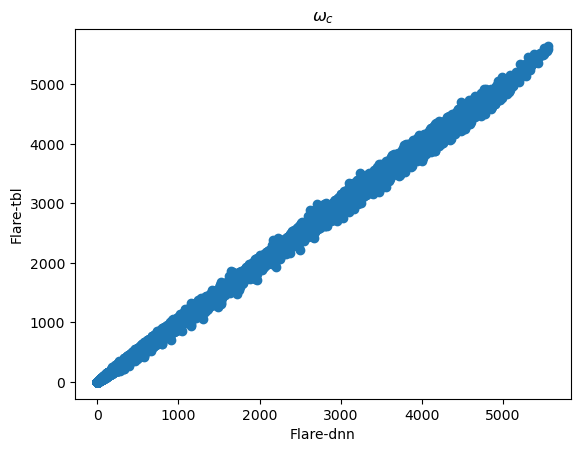

In [22]:
import matplotlib.pyplot as plt
k=0
plt.scatter(predictions[:,k],ytrue[:,k])
plt.xlabel("Flare-dnn")
plt.ylabel("Flare-tbl")
plt.title('$\omega_{c}$')
plt.savefig("omega_c.png")
plt.show()

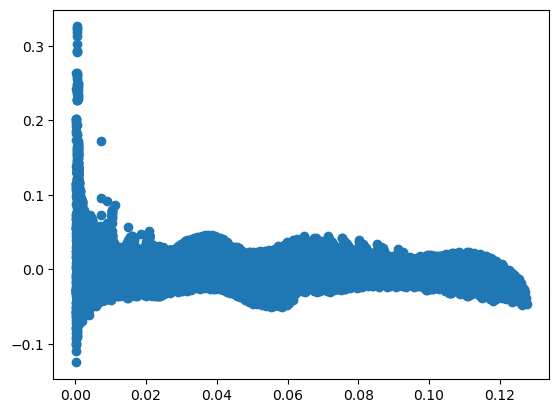

In [40]:
k=10
relative_error=(predictions[:,k]-ytrue[:,k])/ytrue[:,k]
plt.scatter(ytrue[:,k],relative_error)
# print(np.where(relative_error>2))
# print(predictions[:,k][381],ytrue[:,k][381])
plt.show()

# DeepNet网络结构以及训练和预测

In [29]:
class BasicBlock(nn.Module):
    # 判断残差结构中，主分支的卷积核个数是否发生变化，不变则为1
    # init()：进行初始化，申明模型中各层的定义
    # downsample=None对应实线残差结构，否则为虚线残差结构
    def __init__(self, n_input,n_hidden,downsample=None):
        super(BasicBlock, self).__init__()
        self.hidden1 = nn.Linear(n_input,n_hidden)
        # 使用ReLU作为激活函数
        self.relu = nn.ReLU()
 
    # forward()：定义前向传播过程,描述了各层之间的连接关系
    def forward(self, x):
        # 残差块保留原始输入
 
        out = self.hidden1(x)
        out = self.relu(out)
 
        return out

class DeepNet(nn.Module):
    def __init__(self,block,block_num,neuron_num,n_input,n_output):
        super(DeepNet, self).__init__()
        self.neuron=neuron_num
        self.input_layer=nn.Linear(n_input,self.neuron)
        self.deep_layer = self._make_layer(block,block_num)
        self.output_layer=nn.Linear(self.neuron,n_output)
    def _make_layer(self, block,block_num):
        # 如果满足条件，则是虚线残差结构
        layers = []
        for i in range(1, block_num):
            layers.append(block(self.neuron,self.neuron)) 
        return nn.Sequential(*layers)
    def forward(self,input):
        out = self.input_layer(input)
        out = F.relu(out)
        out = self.deep_layer(out)
        out = F.relu(out)
        out = self.output_layer(out)
        return out

In [30]:
blocknum=2
neuronum=200
inputnum=4
outputnum=11
dirpart='_'+str(blocknum)+'_'+str(neuronum)

In [31]:
import torch
import torch.utils.data as Data

model= DeepNet(BasicBlock,blocknum,neuronum,inputnum,outputnum)
# params = torch.load(savedir_train) # 加载参数
# ResNet4_100.load_state_dict(params) # 应用到网络结构中
optimizer = torch.optim.Adam(model.parameters(),lr = lr_train,weight_decay=weight_decay_train)
loss_func = torch.nn.MSELoss()
if(torch.cuda.is_available()):
    DeepNet_cuda = model.cuda()
    loss_func_cuda = loss_func.cuda()
# model = ResNet(BasicBlock,4,100,4,11) # 代码中创建网络结构
# model=  model.cuda()
# params = torch.load("modeldnn_gpu"+dirpart+".pth") # 加载参数
# DeepNet_cuda.load_state_dict(params) # 应用到网络结构中
x_train = torch.tensor(x_train,dtype=torch.float)
y_train = torch.tensor(y_train,dtype=torch.float)
x_test = torch.tensor(x_test,dtype=torch.float)
y_test = torch.tensor(y_test,dtype=torch.float)
x_train_cuda = x_train.cuda()
y_train_cuda = y_train.cuda()
x_test_cuda = x_test.cuda()
y_test_cuda = y_test.cuda()
torch_dataset = Data.TensorDataset(x_train, y_train)    # 得到一个元组(x, y)
torch_dataset_cuda = Data.TensorDataset(x_train_cuda, y_train_cuda) 
# 将dataset 放入DataLoader
loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=batch_size_train,
    shuffle=True,  # 每次训练打乱数据， 默认为False
    num_workers=0,  # 使用多进行程读取数据， 默认0，为不使用多进程
)
loader_cuda = Data.DataLoader(
    dataset=torch_dataset_cuda,
    batch_size=batch_size_train,
    shuffle=True,  # 每次训练打乱数据， 默认为False
    num_workers=0,  # 使用多进行程读取数据， 默认0，为不使用多进程
)
for epoch in range(epochs_train):
    for step, (batch_x, batch_y) in enumerate(loader_cuda):
            prediction = DeepNet_cuda(batch_x) 
            loss = loss_func_cuda(prediction, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    if epoch % 1 == 0:
        if(torch.cuda.is_available()):
            with torch.no_grad():
                validationprediction=DeepNet_cuda(x_train_cuda)
            lossvalidation=loss_func_cuda(validationprediction,y_train_cuda)
            with torch.no_grad():
                testprediction=DeepNet_cuda(x_test_cuda)
            losstest=loss_func_cuda(testprediction,y_test_cuda)
            lossvalidation=lossvalidation.to("cpu")
            losstest=losstest.to("cpu")
            print(epoch,"train loss",lossvalidation.data.numpy()," test loss",losstest.data.numpy())
    if epoch % 50 == 0:
        path_save="modeldnn_gpu"+dirpart+"_"+str(epoch)+".pth"
        torch.save(DeepNet_cuda.state_dict(),path_save)

C:\Users\97252\AppData\Local\Temp\ipykernel_26916\3383807253.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train,dtype=torch.float)
C:\Users\97252\AppData\Local\Temp\ipykernel_26916\3383807253.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train,dtype=torch.float)
C:\Users\97252\AppData\Local\Temp\ipykernel_26916\3383807253.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test,dtype=torch.float)
C:\Users\97252\AppData\Local\Temp\ipykernel_26916\3383

0 train loss 0.99679875  test loss 1.0003861
1 train loss 0.9848749  test loss 0.98840415
2 train loss 0.97344524  test loss 0.97691065
3 train loss 0.9622146  test loss 0.9656117


KeyboardInterrupt: 

In [32]:
torch.save(DeepNet_cuda.state_dict(),"modeldnn_gpu"+dirpart+".pth")

In [34]:
import torch
ytrue=np.load('Ydata_delete.npy')
x=np.load('Xdata_process.npy')
x = torch.tensor(x,dtype=torch.float)
x_cuda=x.cuda()
model = DeepNet(BasicBlock,blocknum,neuronum,inputnum,outputnum)
DeepNet_cuda=  model.cuda()
params = torch.load("modeldnn_gpu"+dirpart+".pth") # 加载参数
DeepNet_cuda.load_state_dict(params) # 应用到网络结构中
if(torch.cuda.is_available()):
    with torch.no_grad():   
        predictions=ResNet_cuda(x_cuda)
predictions=predictions.to("cpu")
predictions=predictions.data.numpy()
phimeans=np.load("phimeans.npy")
phistds=np.load("phistds.npy")
for k in range(11):
    predictions[:,k]=np.power((predictions[:,k]*phistds[k]+phimeans[k]),3)
np.save("Ydata_predictions",predictions)

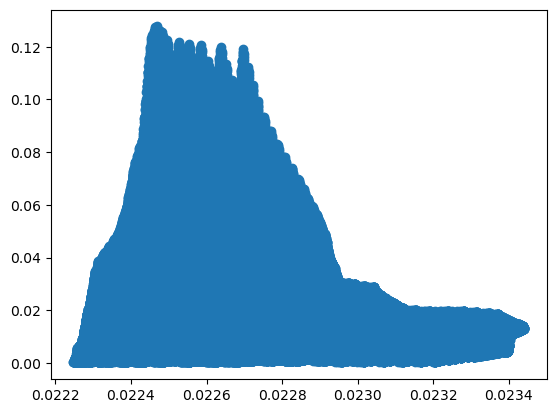

In [35]:
import matplotlib.pyplot as plt
k=10
plt.scatter(predictions[:,k],ytrue[:,k])
plt.show()

In [55]:
phinum=9
for num in (1,2,3,15,30,45,60):
    import numpy as np
    data = np.genfromtxt(str(num)+'.csv', delimiter=',')
    # print(data)
    # result = data * 2
    # np.savetxt('result.csv', result, delimiter=',')
    data=data[1:,[5,7,9,10]]
    import numpy as np
    import torch
    import csv
    import pandas as pd
    x=data
    x_copy = np.copy(x)
    x_copy[:, [1, 2]] = x[:, [2, 1]]
    x=x_copy
    x[:,2]=x[:,2]/(x[:,0]*(1-x[:,0]))
    x[:,3]=x[:,3]/(x[:,1]*(1-x[:,1]))
    x = torch.tensor(x,dtype=torch.float)
    x_cuda=x.cuda()
    model = ResNet(BasicBlock,9,300,4,11)
    ResNet_cuda=  model.cuda()
    params = torch.load("model_gpu_9_300.pth") # 加载参数
    ResNet_cuda.load_state_dict(params) # 应用到网络结构中
    if(torch.cuda.is_available()):
        with torch.no_grad():   
            predictions=ResNet_cuda(x_cuda)
    predictions=predictions.to("cpu")
    predictions=predictions.data.numpy()
    phimeans=np.load("phimeans.npy")
    phistds=np.load("phistds.npy")
    for k in range(11):
        predictions[:,k]=np.power((predictions[:,k]*phistds[k]+phimeans[k]),3)
    a,b=np.shape(predictions)
    dnnphi=np.reshape(predictions[:,phinum],(a,1))
    data2 = pd.DataFrame(dnnphi, columns=[str(phinum)+"-dnn"])
    # 读取 CSV 文件
    data1 = pd.read_csv(str(num)+".csv")
    data1["YCO-dnn"] = data2[str(phinum)+"-dnn"]
    # 将更新后的数据写入 CSV 文件
    data1.to_csv("output"+str(num)+".csv", index=False)

In [61]:
phinum=0
for num in (1,2,3,15,30,45,60):
    import numpy as np
    data = np.genfromtxt(str(num)+'.csv', delimiter=',')
    # print(data)
    # result = data * 2
    # np.savetxt('result.csv', result, delimiter=',')
    data=data[1:,[5,7,9,10]]
    import numpy as np
    import torch
    import csv
    import pandas as pd
    x=data
    x_copy = np.copy(x)
    x_copy[:, [1, 2]] = x[:, [2, 1]]
    x=x_copy
    x[:,2]=x[:,2]/(x[:,0]*(1-x[:,0]))
    x[:,3]=x[:,3]/(x[:,1]*(1-x[:,1]))
    x = torch.tensor(x,dtype=torch.float)
    x_cuda=x.cuda()
    model = ResNet(BasicBlock,9,300,4,1)
    ResNet_cuda=  model.cuda()
    params = torch.load("model_gpu_9_300_T.pth") # 加载参数
    ResNet_cuda.load_state_dict(params) # 应用到网络结构中
    if(torch.cuda.is_available()):
        with torch.no_grad():   
            predictions=ResNet_cuda(x_cuda)
    predictions=predictions.to("cpu")
    predictions=predictions.data.numpy()
    predictions=np.reshape(predictions,(a,1))
    print(np.shape(predictions))
    phimeans=np.load("phimeans.npy")
    phistds=np.load("phistds.npy")
    for k in range(1):
        predictions[:,k]=np.power((predictions[:,k]*phistds[6]+phimeans[6]),3)
#     a,b=np.shape(predictions)
    dnnphi=np.reshape(predictions[:,phinum],(a,1))
    print(dnnphi)
    data2 = pd.DataFrame(dnnphi, columns=[str(phinum)+"-dnn"])
    # 读取 CSV 文件
    data1 = pd.read_csv(str(num)+".csv")
    data1["T-dnn"] = data2[str(phinum)+"-dnn"]
    # 将更新后的数据写入 CSV 文件
    data1.to_csv("output_T"+str(num)+".csv", index=False)

(1001, 1)
[[591.81934]
 [591.67035]
 [591.6675 ]
 ...
 [552.6806 ]
 [552.7049 ]
 [552.7359 ]]
(1001, 1)
[[592.0237 ]
 [591.9682 ]
 [591.9523 ]
 ...
 [552.5602 ]
 [552.5656 ]
 [552.57214]]
(1001, 1)
[[592.2561]
 [592.2147]
 [592.1735]
 ...
 [552.5635]
 [552.5725]
 [552.5858]]
(1001, 1)
[[592.39655]
 [592.54767]
 [592.7225 ]
 ...
 [552.77136]
 [552.7787 ]
 [552.7889 ]]
(1001, 1)
[[576.18604]
 [576.16425]
 [576.14166]
 ...
 [552.94617]
 [552.95294]
 [552.96234]]
(1001, 1)
[[559.53796]
 [559.53467]
 [559.5311 ]
 ...
 [553.1407 ]
 [553.1434 ]
 [553.14667]]
(1001, 1)
[[534.6893 ]
 [534.687  ]
 [534.677  ]
 ...
 [552.8207 ]
 [552.84515]
 [552.9003 ]]
